In [ ]:
# Import library that needed for colab
from google.colab import drive # colab only
from google.colab import files # colab only

import os
import re
import random
import zipfile
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt


from PIL import Image
from tqdm import tqdm

from shutil import move
from shutil import copy
from shutil import make_archive
from shutil import rmtree

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from tensorflow import lite, cast, float32
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import AveragePooling2D, Dense, BatchNormalization, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.applications import MobileNet, MobileNetV2, VGG16, EfficientNetB0, InceptionV3, \
                                           VGG19, Xception, DenseNet121, DenseNet201, ResNet152V2, EfficientNetB5

In [ ]:
# Upload the .json file kaggle api to the colab
files.upload()

# install some requirements for kaggle
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

Saving kaggle.json to kaggle.json
kaggle.json


In [ ]:
# if want to jump to using pre-trained model (model.h5) with transfer learning
def load_models(url, summary=False, filenames='tmp'):
    # Download the model file from the specified URL
    model_download = download_file(url, unzip=False, remove_after_unzip=True, google_drive=True, ext="h5", filename=filenames)

    # Load the downloaded model
    model = load_model(model_download)

    # Display the model summary if the 'summary' flag is set to True
    if summary:
        model.summary()

    # Return the loaded model
    return model

In [ ]:
# Downloading the datasets using Kaggle API
# source: https://www.kaggle.com/datasets/huberthamelin/garbage-classification-labels-corrections
! kaggle datasets download -d huberthamelin/garbage-classification-labels-corrections

 95% 228M/239M [00:02<00:00, 141MB/s]
100% 239M/239M [00:02<00:00, 114MB/s]


In [ ]:
# Extracting the datasets
local_zip = f'{os.getcwd()}/garbage-classification-labels-corrections.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(f'{os.getcwd()}/')
zip_ref.close()

# Removing the old 'huge' zip
rmtree(f'{os.getcwd()}/garbage_classification_corrected/')
os.remove(f'{os.getcwd()}/garbage-classification-labels-corrections.zip')

In [ ]:
# Path where our data is located
base_path = f"{os.getcwd()}/garbage_classification_enhanced/"

# Dictionary to save our 12 classes
categories = ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes',
              'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']

In [ ]:
# Add class name prefix to filename. So for example "/paper104.jpg" become "paper/paper104.jpg"
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search("\d",x).start()] + '/' + x)
    return df

# list conatining all the filenames in the dataset
filenames_list = []
# list to store the corresponding category, note that each folder of the dataset has one class of data
categories_list = []

for category in categories:
    filenames = os.listdir(base_path + category)

    filenames_list += filenames
    categories_list += [category] * len(filenames)

df = pd.DataFrame({
    'filename': filenames_list,
    'category': categories_list
})

df = add_class_name_prefix(df, 'filename')

df = df.sample(frac=1).reset_index(drop=True)

# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)

print('number of elements = ' , len(df))

number of elements =  15870


In [ ]:
df.head()

,filename,category
0,clothes/clothes2243.jpg,clothes
1,white-glass/white-glass60.jpg,white-glass
2,clothes/clothes4324.jpg,clothes
3,clothes/clothes1329.jpg,clothes
4,shoes/shoes397.jpg,shoes


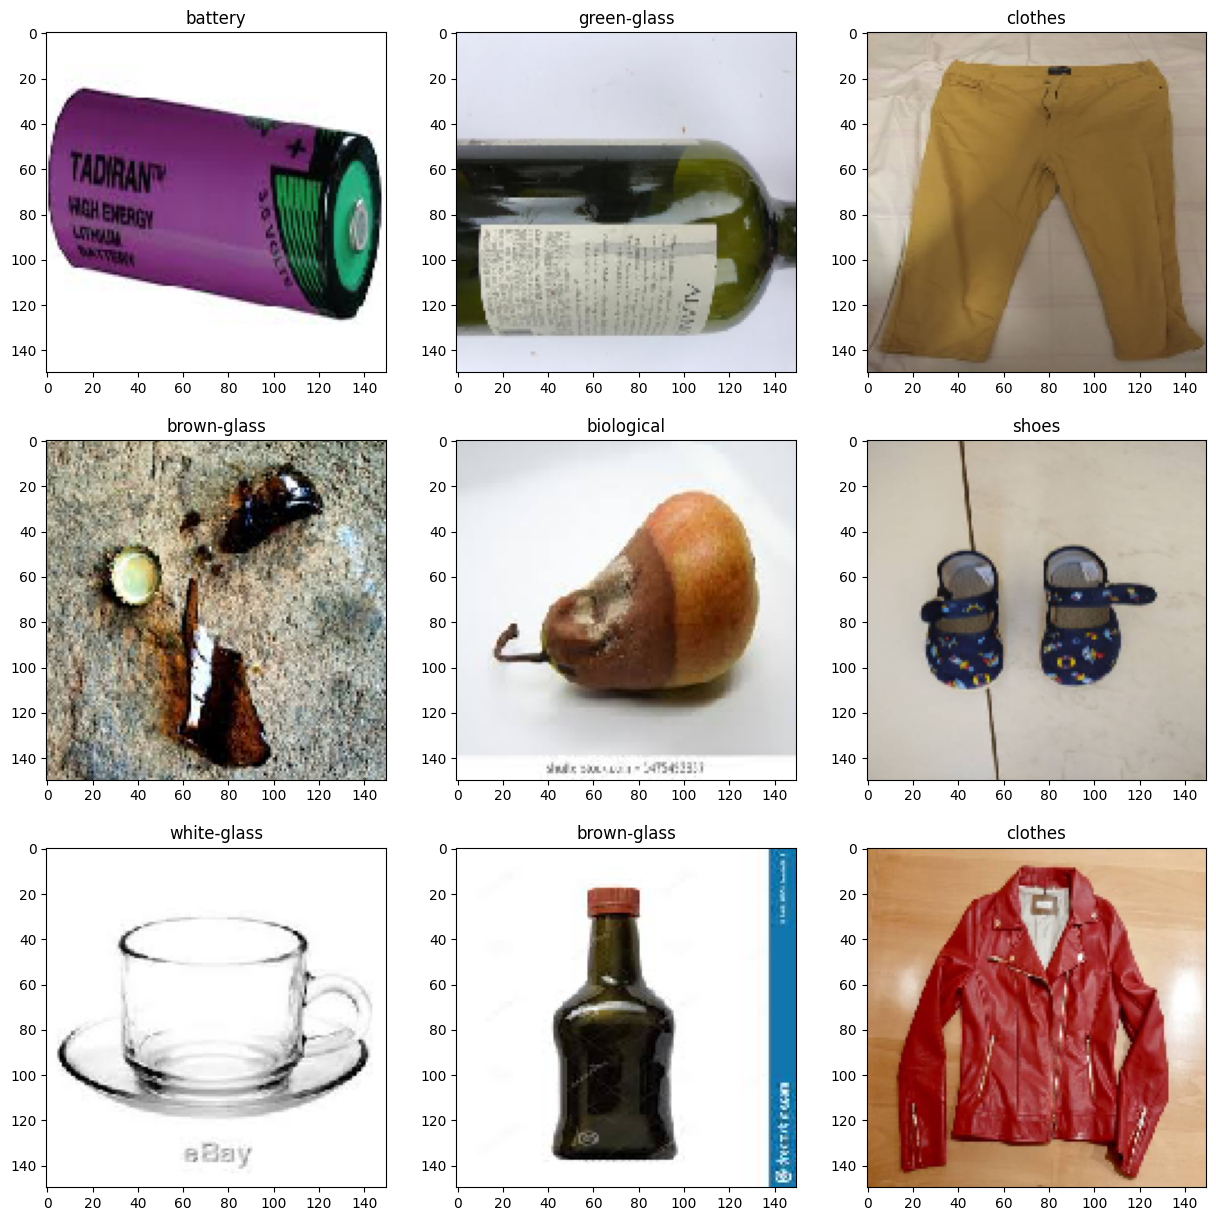

In [ ]:
# see sample image, you can run the same cell again to get a different image
plt.figure(figsize=(15,15))
for i in range(9):
    random_row = random.randint(0, len(df)-1)
    sample = df.iloc[random_row]
    random_image = tf.keras.utils.load_img(base_path + sample['filename'], target_size=(150, 150))
    plt.subplot(330 + 1 + i)
    plt.title(sample['category'])
    plt.imshow(random_image)
plt.show()

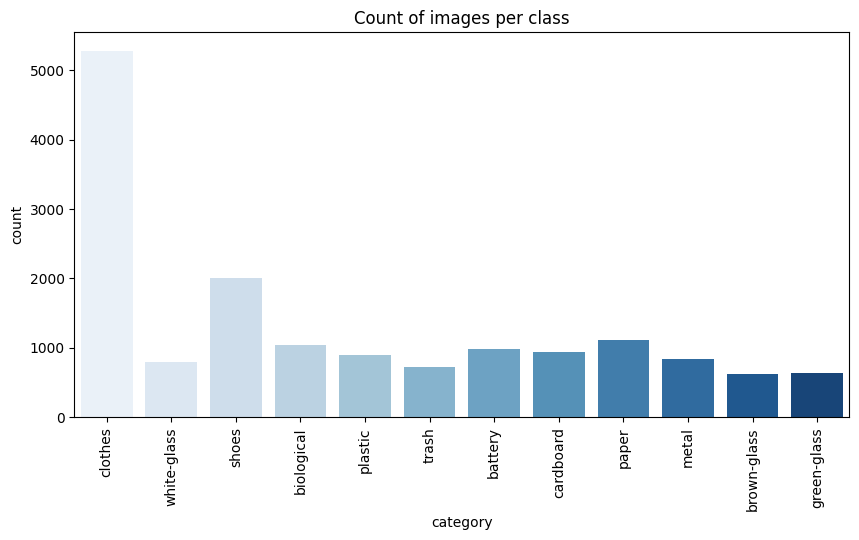

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(x="category", data=df, palette='Blues')
plt.xticks(rotation=90)
plt.title('Count of images per class')
plt.show()

In [ ]:
# We first split the data into two sets and then split the validate_df to two sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=42)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print('train size = ', train_df.shape[0] , 'validate size = ', val_df.shape[0], 'test size = ', test_df.shape[0])

train size =  12696 validate size =  1587 test size =  1587


In [ ]:
train_df

,filename,category
0,battery/battery489.jpg,battery
1,battery/battery588.jpg,battery
2,clothes/clothes3258.jpg,clothes
3,clothes/clothes1373.jpg,clothes
4,white-glass/white-glass377.jpg,white-glass
...,...,...
12691,brown-glass/brown-glass594.jpg,brown-glass
12692,trash/trash366.jpg,trash
12693,clothes/clothes1526.jpg,clothes
12694,clothes/clothes4114.jpg,clothes


In [ ]:
batch_size = 64
size = 256
seed = 42
epoch = 50

train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=base_path,
    x_col='filename',
    y_col='category',
    target_size=(size, size),
    class_mode='categorical',
    batch_size=batch_size,
    seed=seed)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=base_path,
    x_col='filename',
    y_col='category',
    target_size=(size, size),
    class_mode='categorical',
    batch_size=batch_size,
    seed=seed)

test_data_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_data_gen.flow_from_dataframe(
    dataframe=test_df,
    directory=base_path,
    x_col='filename',
    y_col='category',
    target_size=(size, size),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False,
    seed=seed)

Found 12656 validated image filenames belonging to 12 classes.
Found 1582 validated image filenames belonging to 12 classes.
Found 1583 validated image filenames belonging to 12 classes.


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 40 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 5 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 4 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
nb_train_samples = train_generator.samples
nb_validation_samples = val_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes: ' + str(classes))
num_classes  = len(classes)

Classes: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


In [ ]:
# Define the model architecture 1 with regular CNN
model = Sequential([
    # Convolutional layer with 4th layers, each of size 3x3 with respective filter, and ReLU activation
    Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(size, size, 3)),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(32, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(64, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(64, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    # Flatten the output from the previous layer
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    # Output layer with 12 units and softmax activation for multi-class classification
    Dense(num_classes, activation='softmax')
])

model.summary()

# Compile model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_16 (Conv2D)          (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 30, 30, 64)      

In [ ]:
epochs = 20

# Callback to save the best model
callbacks_list = [
    ModelCheckpoint(filepath='model.h5',monitor='val_loss', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10,verbose=1)
]

# Training
history = model.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=val_generator,
        verbose = 1,
        validation_steps=nb_validation_samples // batch_size)

Epoch 1/20
197/197 [==============================] - ETA: 0s - loss: 1.7099 - accuracy: 0.4404
Epoch 1: val_loss improved from inf to 1.18104, saving model to model.h5
197/197 [==============================] - 69s 338ms/step - loss: 1.7099 - accuracy: 0.4404 - val_loss: 1.1810 - val_accuracy: 0.6003
Epoch 2/20
197/197 [==============================] - ETA: 0s - loss: 1.1676 - accuracy: 0.6137
Epoch 2: val_loss improved from 1.18104 to 0.97739, saving model to model.h5
197/197 [==============================] - 65s 329ms/step - loss: 1.1676 - accuracy: 0.6137 - val_loss: 0.9774 - val_accuracy: 0.6738
Epoch 3/20
197/197 [==============================] - ETA: 0s - loss: 0.9676 - accuracy: 0.6865
Epoch 3: val_loss improved from 0.97739 to 0.87593, saving model to model.h5
197/197 [==============================] - 65s 329ms/step - loss: 0.9676 - accuracy: 0.6865 - val_loss: 0.8759 - val_accuracy: 0.7201
Epoch 4/20
197/197 [==============================] - ETA: 0s - loss: 0.8271 - accu

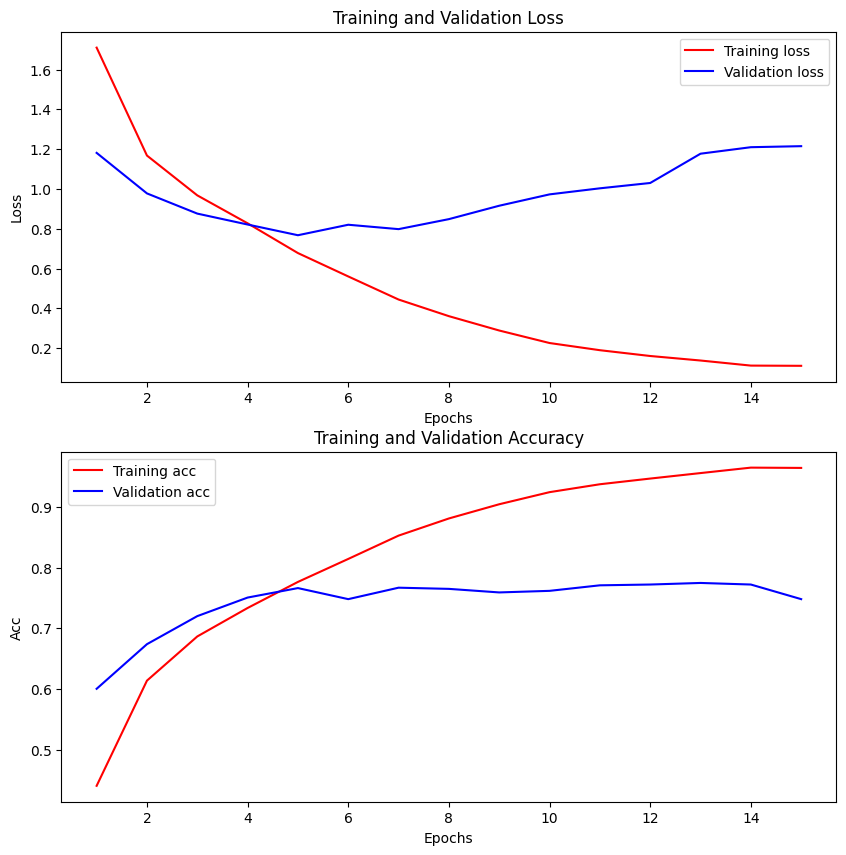

In [ ]:
# Training curves
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, color='r', label='Training loss')
plt.plot(epochs_x, val_loss_values, color='b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2,1,2)
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs_x, acc_values, color='r', label='Training acc')
plt.plot(epochs_x, val_acc_values, color='b', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [ ]:
model = load_model('model.h5')

In [ ]:
# Using the validation dataset
score = model.evaluate(val_generator)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

25/25 [==============================] - 6s 253ms/step - loss: 0.7724 - accuracy: 0.7674
Val loss: 0.7724334001541138
Val accuracy: 0.7673830389976501


In [ ]:
score = model.evaluate(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

1583/1583 [==============================] - 9s 6ms/step - loss: 0.8202 - accuracy: 0.7435
Test loss: 0.8202473521232605
Test accuracy: 0.743524968624115


In [ ]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

1583/1583 [==============================] - 7s 4ms/step
Classification Report
              precision    recall  f1-score   support

     battery       0.69      0.69      0.69        89
  biological       0.65      0.74      0.69       107
 brown-glass       0.87      0.57      0.68        69
   cardboard       0.63      0.66      0.65        86
     clothes       0.85      0.97      0.91       541
 green-glass       0.81      0.97      0.88        59
       metal       0.59      0.46      0.52        80
       paper       0.71      0.72      0.71       113
     plastic       0.54      0.42      0.47        86
       shoes       0.69      0.62      0.65       192
       trash       0.63      0.60      0.61        78
 white-glass       0.68      0.46      0.55        83

    accuracy                           0.74      1583
   macro avg       0.69      0.66      0.67      1583
weighted avg       0.73      0.74      0.73      1583



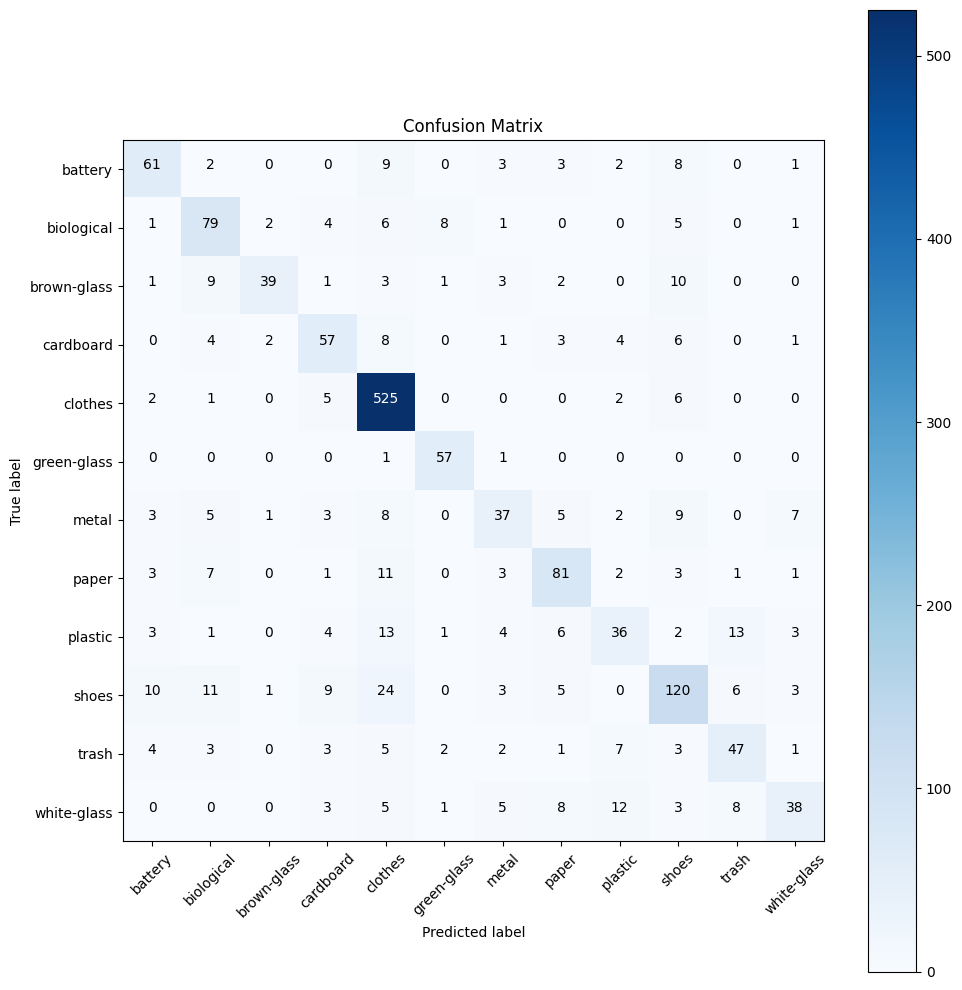

In [ ]:
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

# Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

In [ ]:
# Define the model architecture 2 with pre-trained model as top layer and CNN model as bottom layer
base_model = Xception(weights='imagenet', include_top=False, input_shape=(size, size, 3))

model = Sequential([
    base_model,
    Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(size, size, 3)),
    MaxPooling2D(pool_size=(2,2)),
    AveragePooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    # Dense(256, activation='relu'),
    Dense(num_classes, activation='softmax', kernel_initializer='random_uniform')
])

In [ ]:
# And then fine-tuning to get better accuracy
base_model.trainable = True

In [ ]:
# How many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

# How many layers are in the model after fine tuning
print("Number of trainable layers in the model: ", len(model.trainable_variables))

Number of layers in the base model:  132
Number of trainable layers in the model:  45


In [ ]:
def adjust_learning_rate(model):

    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 6))
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-8)

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["mae"])
    history = model.fit(train_generator, epochs=30, callbacks=[lr_schedule])

    return history

In [ ]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate(model)

Epoch 1/30
198/198 [==============================] - 156s 745ms/step - loss: 0.0137 - mae: 0.0011 - lr: 1.0000e-06
Epoch 2/30
198/198 [==============================] - 95s 479ms/step - loss: 0.0152 - mae: 0.0011 - lr: 1.4678e-06
Epoch 3/30
198/198 [==============================] - 96s 483ms/step - loss: 0.0134 - mae: 9.8861e-04 - lr: 2.1544e-06
Epoch 4/30
198/198 [==============================] - 95s 481ms/step - loss: 0.0121 - mae: 9.8706e-04 - lr: 3.1623e-06
Epoch 5/30
198/198 [==============================] - 95s 481ms/step - loss: 0.0110 - mae: 8.5866e-04 - lr: 4.6416e-06
Epoch 6/30
198/198 [==============================] - 95s 478ms/step - loss: 0.0096 - mae: 7.1192e-04 - lr: 6.8129e-06
Epoch 7/30
198/198 [==============================] - 96s 483ms/step - loss: 0.0058 - mae: 5.4360e-04 - lr: 1.0000e-05
Epoch 8/30
198/198 [==============================] - 96s 482ms/step - loss: 0.0050 - mae: 4.8120e-04 - lr: 1.4678e-05
Epoch 9/30
198/198 [==============================] - 9

(1e-06, 0.1, 0.0, 0.4)

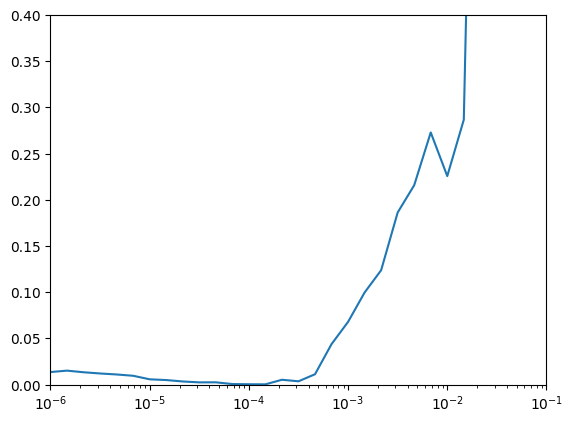

In [ ]:
# Run the training with dynamic learning rate to find best value
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([1e-6, 1e-1, 0, 0.4])

In [ ]:
# After adjust learning rate go back to model architecture 2 and run it again
model.compile(optimizer = Adam(lr=1.47e-04), loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 conv2d_13 (Conv2D)          (None, 6, 6, 32)          589856    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 3, 3, 32)         0         
 2D)                                                             
                                                                 
 average_pooling2d_1 (Averag  (None, 1, 1, 32)         0         
 ePooling2D)                                                     
                                                                 
 flatten_2 (Flatten)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 128)              

In [ ]:
epochs = 30

# Callback to save the best model
callbacks_list = [
    ModelCheckpoint(filepath = 'model_Xception.h5', monitor = 'val_loss', save_best_only = True, verbose = 1),
    EarlyStopping(monitor = 'val_loss', patience = 10, verbose = 1)
]

# Training
history = model.fit(
        train_generator,
        epochs = epochs,
        verbose = 1,
        callbacks = callbacks_list,
        validation_data = val_generator,
        steps_per_epoch = nb_train_samples // batch_size,
        validation_steps = nb_validation_samples // batch_size)

Epoch 1/30
197/197 [==============================] - ETA: 0s - loss: 0.4283 - accuracy: 0.8694
Epoch 1: val_loss improved from inf to 0.23507, saving model to model_Xception.h5
197/197 [==============================] - 120s 561ms/step - loss: 0.4283 - accuracy: 0.8694 - val_loss: 0.2351 - val_accuracy: 0.9362
Epoch 2/30
197/197 [==============================] - ETA: 0s - loss: 0.1441 - accuracy: 0.9573
Epoch 2: val_loss did not improve from 0.23507
197/197 [==============================] - 104s 525ms/step - loss: 0.1441 - accuracy: 0.9573 - val_loss: 0.2758 - val_accuracy: 0.9414
Epoch 3/30
197/197 [==============================] - ETA: 0s - loss: 0.1029 - accuracy: 0.9694
Epoch 3: val_loss did not improve from 0.23507
197/197 [==============================] - 105s 535ms/step - loss: 0.1029 - accuracy: 0.9694 - val_loss: 0.2373 - val_accuracy: 0.9440
Epoch 4/30
197/197 [==============================] - ETA: 0s - loss: 0.0891 - accuracy: 0.9759
Epoch 4: val_loss improved from 0.2

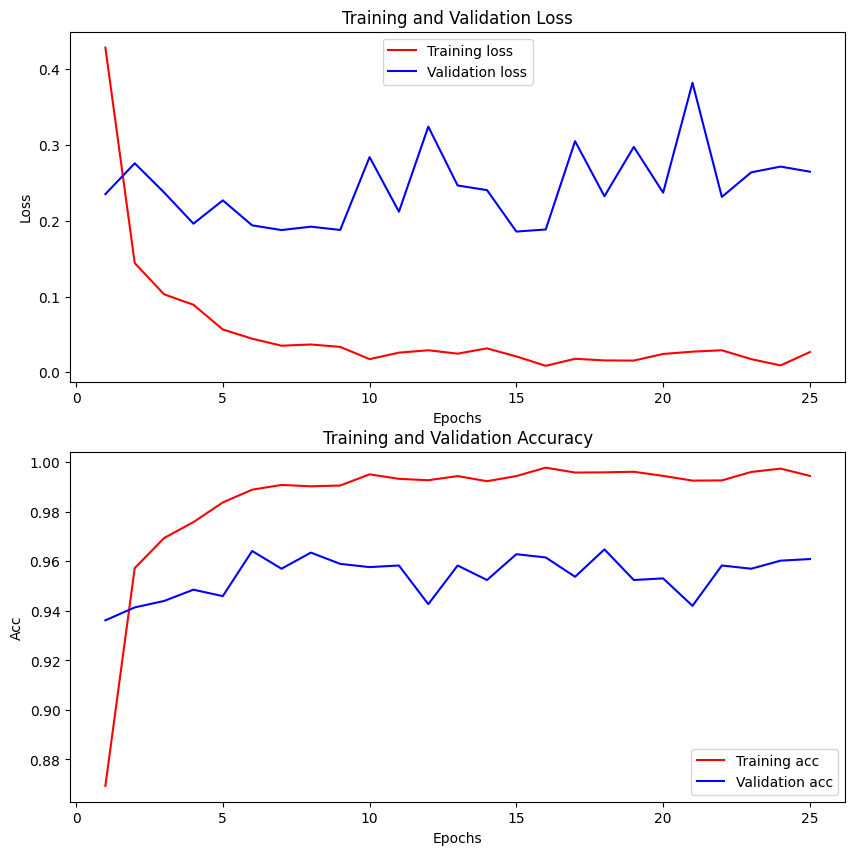

In [ ]:
# Training curves
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, color='r', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2,1,2)
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs_x, acc_values, color='r', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'b', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [ ]:
model = load_model('model_Xception.h5')

In [ ]:
# Using the validation dataset
score = model.evaluate(val_generator)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

25/25 [==============================] - 9s 340ms/step - loss: 0.1803 - accuracy: 0.9640
Validation loss: 0.18033643066883087
Validation accuracy: 0.9639696478843689


In [ ]:
# Using the test dataset
score = model.evaluate(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

1583/1583 [==============================] - 19s 11ms/step - loss: 0.1796 - accuracy: 0.9621
Test loss: 0.17963308095932007
Test accuracy: 0.9620972871780396


1583/1583 [==============================] - 15s 10ms/step
Classification Report
              precision    recall  f1-score   support

     battery       0.97      0.98      0.97        89
  biological       0.98      0.97      0.98       107
 brown-glass       0.97      0.97      0.97        69
   cardboard       0.93      0.95      0.94        86
     clothes       0.99      1.00      1.00       541
 green-glass       0.96      0.93      0.95        59
       metal       0.92      0.89      0.90        80
       paper       0.94      0.94      0.94       113
     plastic       0.82      0.93      0.87        86
       shoes       0.98      0.97      0.98       192
       trash       0.99      0.92      0.95        78
 white-glass       0.91      0.87      0.89        83

    accuracy                           0.96      1583
   macro avg       0.95      0.94      0.95      1583
weighted avg       0.96      0.96      0.96      1583



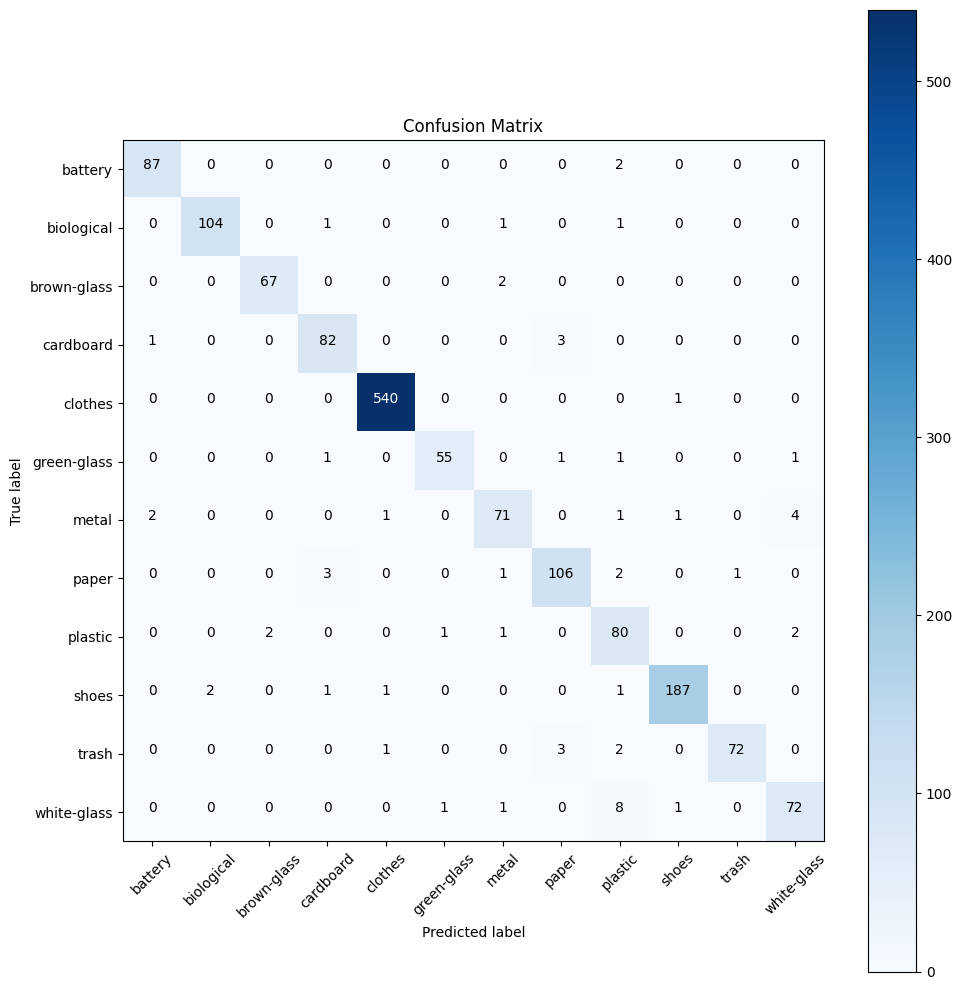

In [ ]:
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

# Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

paper/paper166.jpg
1/1 [==============================] - 0s 26ms/step

Predicting: 100.00% of paper


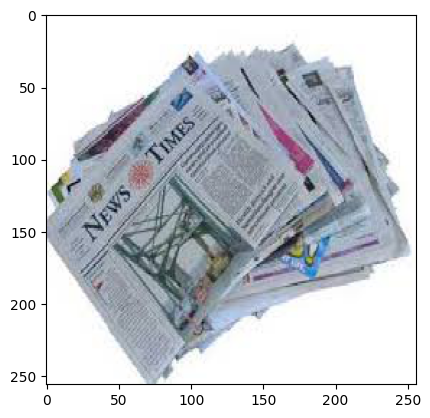

In [ ]:
# test some picture here

# this is for general testing
imgs = []

random_row = random.randint(0, len(df)-1)
sample = df.iloc[random_row]
randomimage = tf.keras.utils.load_img(base_path +sample['filename'], target_size=(256, 256))
img = tf.keras.utils.img_to_array(randomimage)
img = img.astype(np.float32) / 255
print(sample['filename'])
plt.imshow(randomimage)
imgs.append(img)
imgs = np.stack(imgs, axis=0)

predictions = model.predict(imgs)
pred = np.argmax(predictions, axis=1)

print(f"\nPredicting: {(np.max(predictions))*100:.2f}% of {categories[pred[0]]}")

In [ ]:
def to_tflite(path, tflite_filename, optimizations):

    model = load_model(path)
    converter = lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [lite.Optimize.DEFAULT]

    tflite_model = converter.convert()

    with open(tflite_filename, 'wb') as f:
        f.write(tflite_model)

    return tflite_filename

In [ ]:
to_tflite('model_Xception.h5', 'converted_model_Xception.tflite', 'size')

'converted_model_Xception.tflite'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp model.h5 /content/drive/MyDrive
!cp model_Xception.h5 /content/drive/MyDrive
!cp converted_model_Xception.tflite /content/drive/MyDrive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
